📥 Loading model_ready_data from Azure Blob...
Found 403 parquet files.


Downloading: 100%|██████████| 403/403 [00:24<00:00, 16.15it/s]


✅ Combined shape: (4028304, 43)

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028304 entries, 0 to 4028303
Data columns (total 43 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   Date                         datetime64[ns, UTC]
 1   Open                         float64            
 2   High                         float64            
 3   Low                          float64            
 4   Close                        float64            
 5   Adj Close                    float64            
 6   Volume                       int64              
 7   Ticker                       object             
 8   SMA_20                       float64            
 9   EMA_20                       float64            
 10  RSI_14                       float64            
 11  MACD                         float64            
 12  MACD_signal                  float64            
 13  BB_upper            

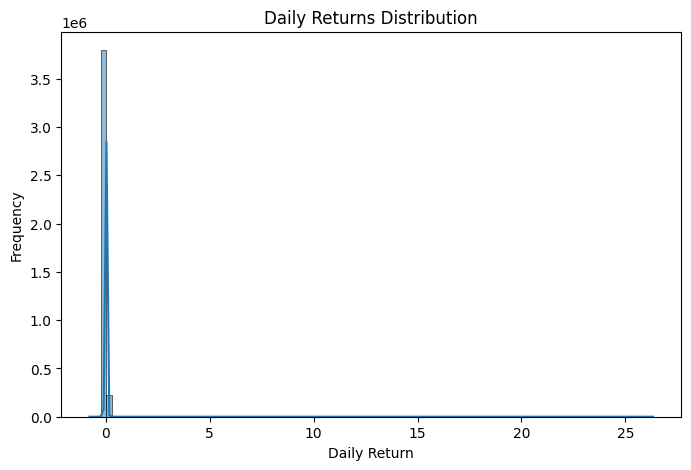

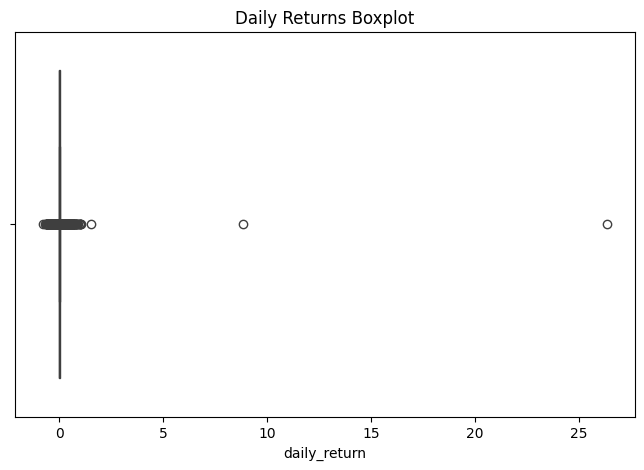

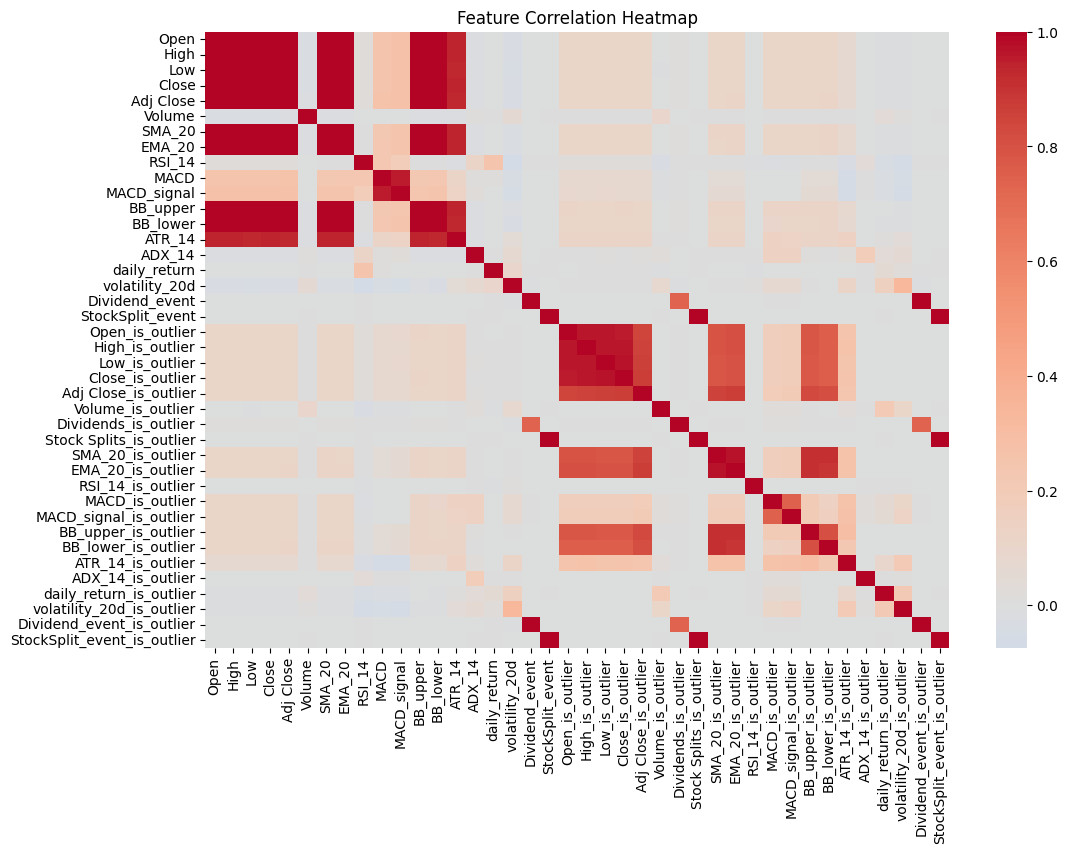


📊 EDA Completed.


In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from azure.storage.blob import BlobServiceClient
from tqdm import tqdm

# ================== CONFIG ==================
import os
from dotenv import load_dotenv

load_dotenv()  # loads .env file if present (for local dev)

AZURE_CONNECTION_STRING = os.getenv("AZURE_CONN_STR")
CONTAINER_NAME = "stock-data"
INPUT_FOLDER = "model_ready_data"   # post-processed data

# Connect to Azure Blob
blob_service_client = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)
container_client = blob_service_client.get_container_client(CONTAINER_NAME)

# ================== LOAD DATA ==================
print("📥 Loading model_ready_data from Azure Blob...")
blobs = [b.name for b in container_client.list_blobs(name_starts_with=INPUT_FOLDER) if b.name.endswith(".parquet")]
print(f"Found {len(blobs)} parquet files.")

df_list = []
for blob_name in tqdm(blobs, desc="Downloading"):
    downloader = container_client.download_blob(blob_name)
    df_temp = pd.read_parquet(io.BytesIO(downloader.readall()))
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)
print(f"✅ Combined shape: {df.shape}")

# ================== BASIC INFO ==================
print("\n=== Basic Info ===")
print(df.info())

print("\n=== Missing Values ===")
print(df.isna().sum().sort_values(ascending=False).head(20))

print("\n=== Duplicate Rows ===")
print(f"Total duplicates: {df.duplicated().sum()}")

# ================== NUMERIC SUMMARY ==================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\n=== Numeric Feature Summary ===")
print(df[numeric_cols].describe().transpose().head(15))

# ================== CATEGORICAL SUMMARY ==================
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("\n=== Categorical Value Counts ===")
for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts().head(10))

# ================== OUTLIER FLAGS ==================
outlier_cols = [c for c in df.columns if c.endswith("_is_outlier")]
outlier_sum = df[outlier_cols].sum().sort_values(ascending=False)
print("\n=== Outlier Flag Counts ===")
print(outlier_sum[outlier_sum > 0])

# ================== PLOTS ==================
plt.figure(figsize=(8,5))
sns.histplot(df["daily_return"], bins=100, kde=True)
plt.title("Daily Returns Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df["daily_return"])
plt.title("Daily Returns Boxplot")
plt.show()

# Correlation heatmap for top numeric features
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

print("\n📊 EDA Completed.")


In [ ]:
!pip install fpdf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.7/245.7 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.11.0 which is incompatible.
azureml-train-automl-runtime 1.60.0 requires urllib3<2.0.0, but you have urllib3 2.5.0 which is incompatible.
azureml-datadrift 1.60.0 requires matplotlib<=3.6.3,>=3.0.2, but you have matplotlib 3.7.1 which is incompatible.


In [ ]:
# =========================
# EDA for model_ready_data
# Generates PDF Report
# =========================

!pip install fpdf matplotlib seaborn

import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
from datetime import datetime
from azure.storage.blob import BlobServiceClient

# ===== CONFIG =====
import os
from dotenv import load_dotenv

load_dotenv()  # loads .env file if present (for local dev)

AZURE_CONNECTION_STRING = os.getenv("AZURE_CONN_STR")
CONTAINER_NAME = "stock-data"
FOLDER = "model_ready_data"
LOCAL_PLOTS_DIR = "eda_plots"
REPORT_FILE = "EDA_Report.pdf"
SAMPLE_FILE_COUNT = 5  # how many files to pull for analysis

# ===== CONNECT TO AZURE =====
blob_service_client = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)
container_client = blob_service_client.get_container_client(CONTAINER_NAME)

# ===== DOWNLOAD SAMPLE FILES =====
os.makedirs(LOCAL_PLOTS_DIR, exist_ok=True)
print("📥 Downloading sample Parquet files...")

parquet_blobs = [b.name for b in container_client.list_blobs(name_starts_with=FOLDER) if b.name.endswith(".parquet")]
sample_blobs = parquet_blobs[:SAMPLE_FILE_COUNT]

df_list = []
for blob_name in sample_blobs:
    data = container_client.download_blob(blob_name).readall()
    df = pd.read_parquet(io.BytesIO(data))
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
print(f"✅ Loaded {len(data)} rows from {len(sample_blobs)} files")

# ===== BASIC INFO =====
basic_info = {
    "num_rows": len(data),
    "num_columns": len(data.columns),
    "columns": list(data.columns),
    "num_tickers": data["Ticker"].nunique() if "Ticker" in data.columns else None,
    "date_range": (data["Date"].min(), data["Date"].max()) if "Date" in data.columns else None
}

# ===== MISSING VALUES =====
missing_values = data.isna().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

# ===== DUPLICATES =====
duplicate_count = data.duplicated().sum()

# ===== OUTLIERS =====
outlier_cols = [c for c in data.columns if c.endswith("_is_outlier")]
outlier_summary = {col: int(data[col].sum()) for col in outlier_cols}

# Find top outlier rows (only if original feature exists)
top_outliers_dict = {}
for col in outlier_cols:
    feature = col.replace("_is_outlier", "")
    if data[col].sum() > 0 and feature in data.columns:
        top_rows = data[data[col] == 1][["Date", "Ticker", feature]].sort_values(by=feature, ascending=False).head(5)
        top_outliers_dict[col] = top_rows

# ===== PLOTS =====
# Price trend for a sample ticker
sample_ticker = data["Ticker"].iloc[0]
ticker_df = data[data["Ticker"] == sample_ticker]
plt.figure(figsize=(8, 4))
plt.plot(ticker_df["Date"], ticker_df["Adj Close"])
plt.title(f"Price Trend - {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Adj Close Price")
plt.tight_layout()
plt.savefig(f"{LOCAL_PLOTS_DIR}/price_trend.png")
plt.close()

# Sector distribution (if available)
if "Sector" in data.columns:
    plt.figure(figsize=(6, 4))
    sector_counts = data["Sector"].value_counts().head(10)
    sns.barplot(x=sector_counts.values, y=sector_counts.index)
    plt.title("Top 10 Sectors by Data Points")
    plt.xlabel("Count")
    plt.ylabel("Sector")
    plt.tight_layout()
    plt.savefig(f"{LOCAL_PLOTS_DIR}/sector_distribution.png")
    plt.close()

# Outlier count distribution
plt.figure(figsize=(8, 4))
outlier_counts = pd.Series(outlier_summary)
outlier_counts.plot(kind="bar")
plt.title("Outlier Counts by Feature")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(f"{LOCAL_PLOTS_DIR}/outlier_counts.png")
plt.close()

# ===== GENERATE PDF =====
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 14)
        self.cell(0, 10, "Stock Data EDA Report", ln=True, align="C")
        self.ln(5)

    def chapter_title(self, title):
        self.set_font("Arial", "B", 12)
        self.cell(0, 8, title, ln=True)
        self.ln(2)

    def chapter_body(self, body):
        self.set_font("Arial", "", 10)
        self.multi_cell(0, 5, body)
        self.ln()

    def add_image(self, img_path, w=180, h=0):
        self.image(img_path, w=w, h=h)
        self.ln(5)

pdf = PDF()
pdf.set_auto_page_break(auto=True, margin=15)

# Page 1 - Summary
pdf.add_page()
pdf.chapter_title("Basic Information")
pdf.chapter_body(str(basic_info))

pdf.chapter_title("Missing Values")
pdf.chapter_body(str(missing_values))

pdf.chapter_title("Duplicate Rows")
pdf.chapter_body(f"Total Duplicates: {duplicate_count}")

pdf.chapter_title("Outlier Summary")
pdf.chapter_body(str(outlier_summary))

# Page 2 - Plots
pdf.add_page()
pdf.chapter_title("Price Trend Example")
pdf.add_image(f"{LOCAL_PLOTS_DIR}/price_trend.png")

if os.path.exists(f"{LOCAL_PLOTS_DIR}/sector_distribution.png"):
    pdf.chapter_title("Sector Distribution")
    pdf.add_image(f"{LOCAL_PLOTS_DIR}/sector_distribution.png")

pdf.chapter_title("Outlier Counts")
pdf.add_image(f"{LOCAL_PLOTS_DIR}/outlier_counts.png")

# Page 3 - Top Outliers
pdf.add_page()
pdf.chapter_title("Top Outliers")
for col, df_out in top_outliers_dict.items():
    pdf.chapter_body(f"{col}:\n{df_out.to_string(index=False)}\n")

# Save PDF
pdf.output(REPORT_FILE)
print(f"📄 EDA report saved as {REPORT_FILE}")


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40758 sha256=5dfc44bbc247ded58c087b597ca2e2bf1cd7cfac2a019981314c48d776e3d2c8
  Stored in directory: /home/azureuser/.cache/pip/wheels/bc/6c/e7/c239668efef980927985e629d58674079552a9de5ec3aebfd8
Successfully built fpdf
📥 Downloading sample Parquet files...
✅ Loaded 45931 rows from 5 files


/tmp/ipykernel_27076/3452969395.py:112: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  self.set_font("Arial", "B", 14)
/tmp/ipykernel_27076/3452969395.py:113: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 10, "Stock Data EDA Report", ln=True, align="C")
/tmp/ipykernel_27076/3452969395.py:117: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  self.set_font("Arial", "B", 12)
/tmp/ipykernel_27076/3452969395.py:118: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 8, title, ln=True)
/tmp/ipykernel_27076/3452969395.py:122: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed

📄 EDA report saved as EDA_Report.pdf
